## Part 1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn')
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
filename = './logins.json'
logins = pd.read_json(filename, convert_dates='login_time')
logins['count'] = 1
logins = logins.set_index('login_time')
logins.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [4]:
quarter_logins = logins.resample('0.25H').sum()
quarter_logins.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [5]:
daily_logins = quarter_logins.resample('D').sum()
daily_logins.head()

,count
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


In [6]:
hourly_logins = quarter_logins.resample('H').sum()
hourly_logins.head()

,count
login_time,
1970-01-01 20:00:00,24
1970-01-01 21:00:00,9
1970-01-01 22:00:00,21
1970-01-01 23:00:00,58
1970-01-02 00:00:00,53


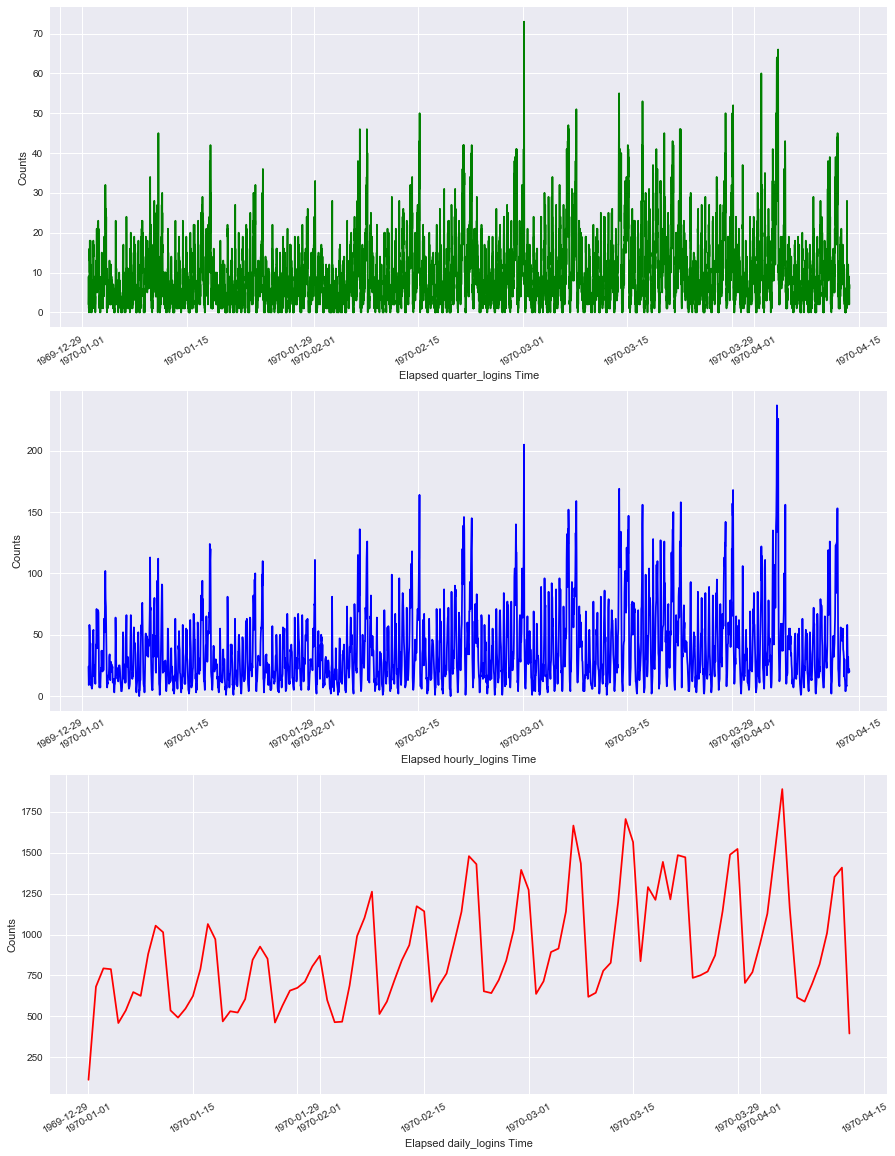

In [7]:
times_list = [quarter_logins, hourly_logins, daily_logins]
times_names = ['quarter_logins','hourly_logins','daily_logins']
colors = ['g','b','r']
#{'quarter_logins':quarter_logins,'hourly_logins':hourly_logins,'daily_logins':daily_logins}
plt.figure(figsize=(15,20))
for i in range(1,4):
    plt.subplot(3,1,i)
    plt.plot(times_list[i-1], color=colors[i-1])
    plt.ylabel('Counts')
    plt.xlabel('Elapsed {} Time'.format(times_names[i-1]))
    plt.xticks(rotation=30)


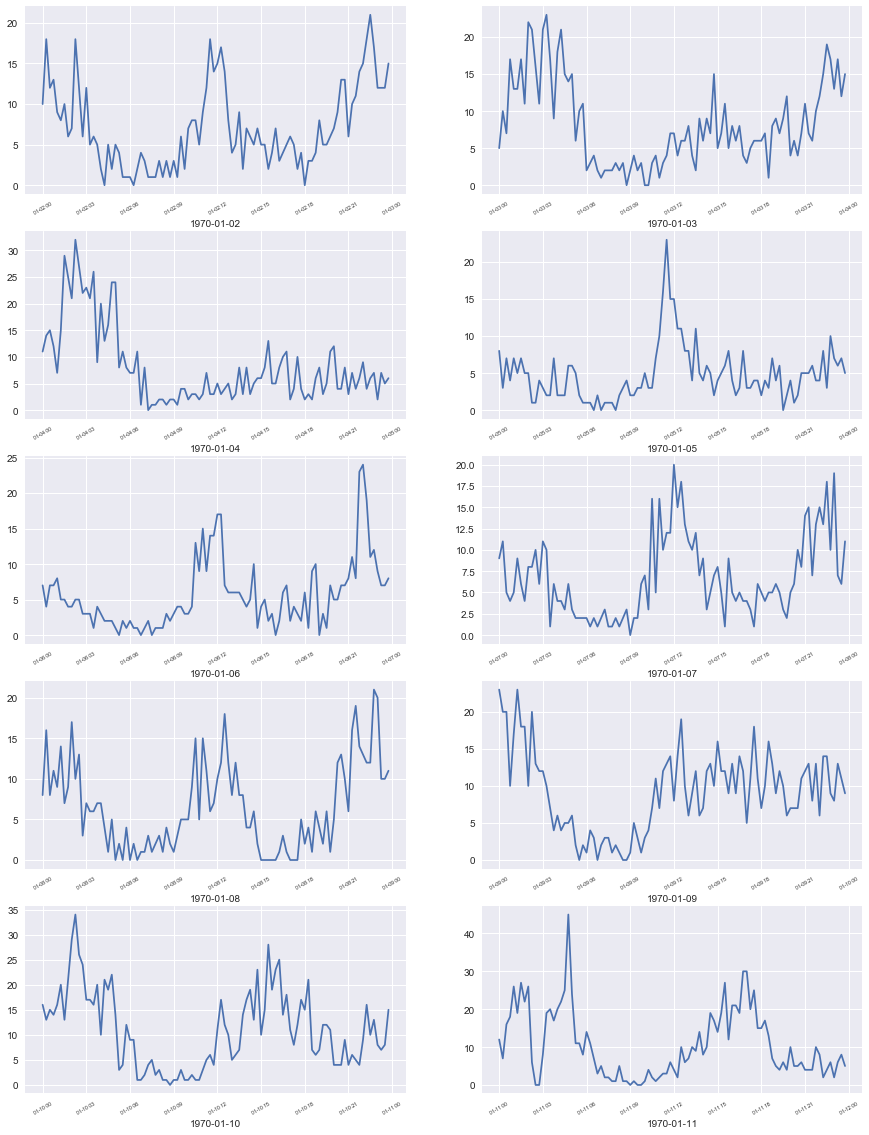

In [8]:
#analyzing daily patterns of sample days in 15-min intervals
sample_day = dict()
plt.figure(figsize=(15,20))
for i in range(1,11):
    sample_day[i] = quarter_logins[quarter_logins.index.date == daily_logins.index.date[i]]
    plt.subplot(5,2,i)
    plt.plot(sample_day[i])
    plt.xlabel(daily_logins.index.date[i], fontsize=10)
    plt.xticks(rotation=30, fontsize=5)

The daily login counts don't seem to show any particular pattern over 15-min intervals, as shown above. 

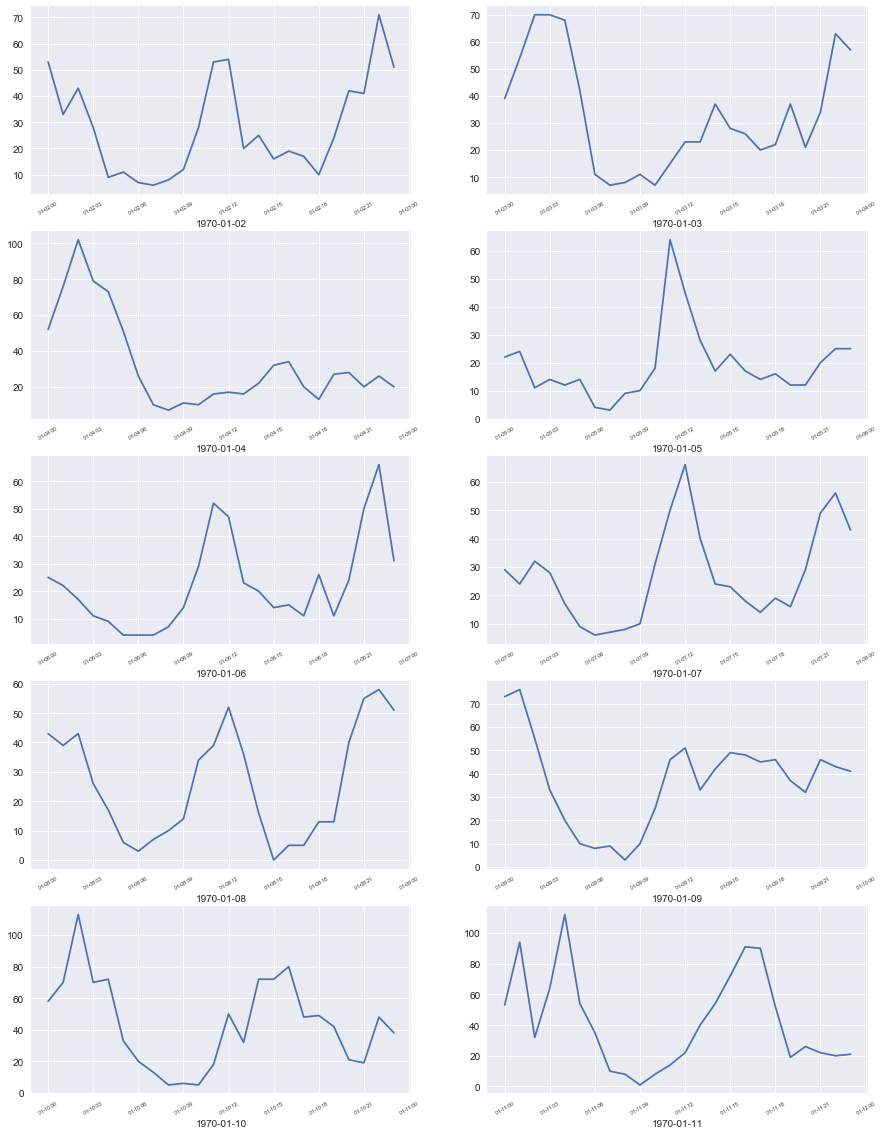

In [9]:
#analysis by hour of sample days
sample_day_by_hour = dict()
plt.figure(figsize=(15,20))
for i in range(1,11):
    sample_day_by_hour[i] = hourly_logins[hourly_logins.index.date == daily_logins.index.date[i]]
    plt.subplot(5,2,i)
    plt.plot(sample_day_by_hour[i])
    plt.xlabel(daily_logins.index.date[i], fontsize=10)
    plt.xticks(rotation=30, fontsize=5)

Hourly analysis reveals trends similar to 15-min interval trends

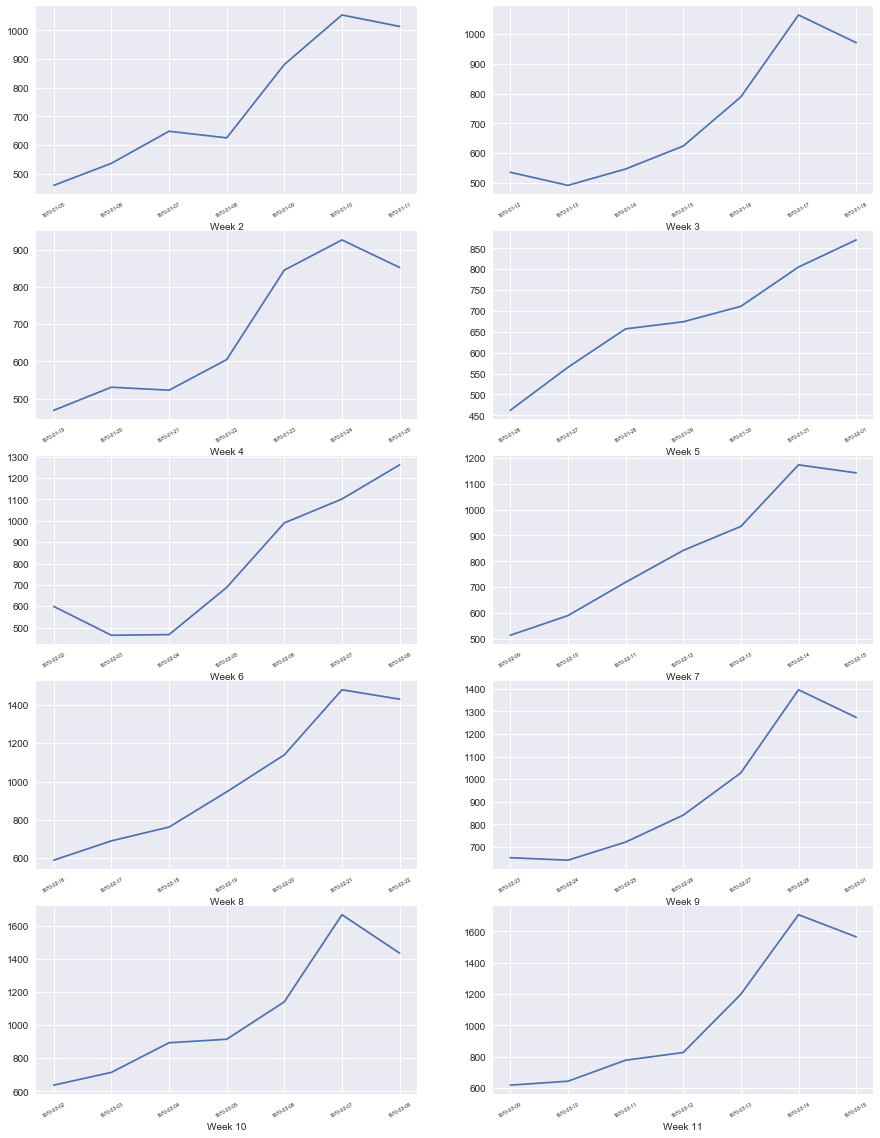

In [10]:
#analysis of random weekly data 
sample_week = dict()
plt.figure(figsize=(15,20))
week = daily_logins.resample('W').sum()
for i in range(1,11):
    sample_week[i] = daily_logins[daily_logins.index.week == week.index.week[i]]
    plt.subplot(5,2,i)
    plt.plot(sample_week[i])
    plt.xlabel('Week {}'.format(week.index.week[i]), fontsize=10)
    plt.xticks(rotation=30, fontsize=5)

One can notice a definite increase in the number of logins over the course of the week. The following graph shows the average number of logins per week.

Text(0.5, 0, 'Day of the week')

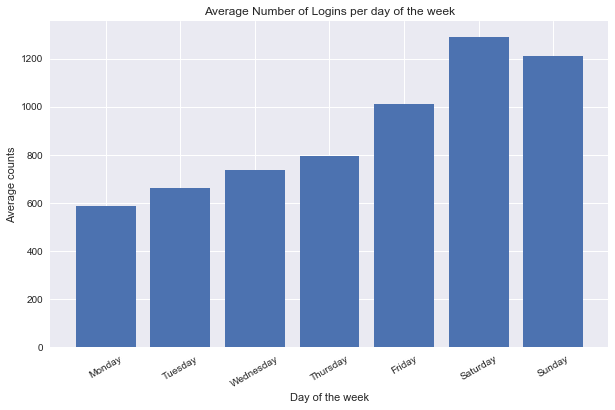

In [11]:
#login results by day of the week
day_logins = daily_logins.groupby(daily_logins.index.dayofweek).mean()
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=(10,6))
plt.bar(day_logins.index, day_logins.iloc[:,0])
plt.xticks([0,1,2,3,4,5,6], days, rotation=30)
plt.title('Average Number of Logins per day of the week')
plt.ylabel('Average counts')
plt.xlabel('Day of the week')

Text(0.5, 0, 'Hour of the day')

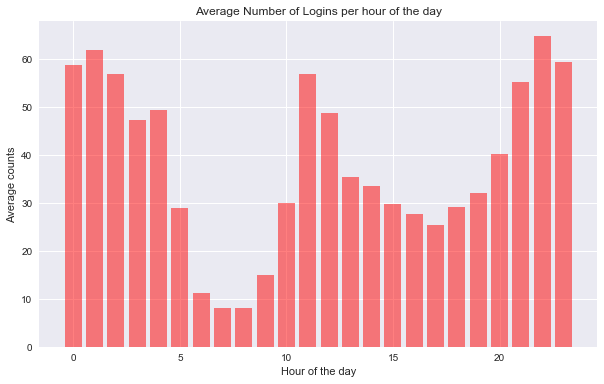

In [12]:
#login results by hour of the day
avg_hour_logins = hourly_logins.groupby(hourly_logins.index.hour).mean()
#days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=(10,6))
plt.bar(avg_hour_logins.index, avg_hour_logins.iloc[:,0], color='r', alpha=0.5)
#plt.xticks([0,1,2,3,4,5,6], days, rotation=30)
plt.title('Average Number of Logins per hour of the day')
plt.ylabel('Average counts')
plt.xlabel('Hour of the day')

It seems that most logins occur in two peaks during the day: around 11AM and around 10PM to 1AM on ab average day. 

In [13]:
quarter_logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
count    9788 non-null int64
dtypes: int64(1)
memory usage: 152.9 KB


## Part 2 - Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

>Given the problem statement, a good metric to monitor is the percentage of rides orginating in one city and ending up in the other during the average weekday shift or the average weeknight shift. If the drivers do not have to pay toll taxes, they wouldn't hesitate to drop people off between cities.  The drivers would in fact want to travel more then to gain more revenue for themselves, and this metric should go up. 
>
>Choosing such a metric would help the managers to directly examine the effect of reimbursing all toll costs on the drivers in both cities during days and nights. 

2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on: <br>
a. how you will implement the experiment <br>
b. what statistical test(s) you will conduct to verify the significance of the
observation <br>
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

>I would implement a 2-week-long A/B test, where 50% of all Ultimate drivers originating in Gotham and 50% of all drivers in Metropolis would pay toll taxes, and the other 50% in each city wouldn't. I would keep track of the number of rides originating in one city and ending up in the other over the 2-week course, and calculate a percentage value based on the total number of rides. 
>
>Then I would compare the distributions of this metric for the two A/B groups, and perform Studentized t-test for comparison of two means to check for significance in difference at the 95% confidence level. I will also check for a confusion matrix, in case there are drivers who believe they are part of the no-toll group when they are not, and drivers who believe they are not when they are. This would help in maintaining high accuracy of the results. 
>
>Ideally, the mean percentage of rides for the no-toll group would be much higher than that for the toll group, and if that is the case, one can point out that the experiment has worked. The caveat is that, unlike a true A/B test with the subjects having no knowledge of the test, the drivers in the no-toll group would need to be told that they are not being charged for the tolls, which would influence their decisions. 

## Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

In [14]:
import json
with open('./ultimate_data_challenge.json') as filename2:
    data = json.load(filename2)
    
ultimate_df = pd.DataFrame(data)
ultimate_df.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0


In [15]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [16]:
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'], yearfirst=True)
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'], yearfirst=True)
ultimate_df.loc[0, 'last_trip_date'].date()

datetime.date(2014, 6, 17)

In [17]:
print('The last date that the users signed up was ' + str(max(ultimate_df.signup_date)))
print('The last date the users took a trip was ' + str(max(ultimate_df.last_trip_date)))

The last date that the users signed up was 2014-01-31 00:00:00
The last date the users took a trip was 2014-07-01 00:00:00


Thus the preceding 30 days would be 2014-06-01 onwards. 

### Imputing the missing values

The missing values for the average ratings of the driver and by the driver are going to be filled in with the mean of their respective columns. We will not be using the data for the missing phone numbers, and dropping those rows.

In [18]:
ultimate_df['avg_rating_by_driver'] = ultimate_df['avg_rating_by_driver'].fillna(round(ultimate_df['avg_rating_by_driver'].mean(),1))
ultimate_df['avg_rating_of_driver'] = ultimate_df['avg_rating_of_driver'].fillna(round(ultimate_df['avg_rating_of_driver'].mean(),1))

In [19]:
ultimate_df.dropna(inplace=True)
ultimate_df.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,4.6,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0
9,2.37,5.0,4.6,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0


In [20]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null object
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               49604 non-null datetime64[ns]
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.6+ MB


### One-hot encoding categorical variables 

Phone and city columns are categorical variables and can be one-hot encoded to ensure that they are properly used as variables in the machine learning model. 

In [21]:
print('The unique values for the phone and city are {0} and {1}, respectively.'.format(ultimate_df.phone.unique(), ultimate_df.city.unique()))

The unique values for the phone and city are ['iPhone' 'Android'] and ["King's Landing" 'Astapor' 'Winterfell'], respectively.


In [22]:
phone_encoded = pd.get_dummies(ultimate_df.phone.apply(pd.Series).stack(),drop_first=True).sum(level=0)
ultimate_df = ultimate_df.join(phone_encoded)

In [23]:
city_encoded = pd.get_dummies(ultimate_df.city.apply(pd.Series).stack(),drop_first=True).sum(level=0)
ultimate_df = ultimate_df.join(city_encoded)

In [24]:
one_hot_df = ultimate_df.drop(columns=['phone','city'])
one_hot_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,iPhone,King's Landing,Winterfell
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,1,1,0
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,0,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,1,0,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,1,1,0
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,1


### Exploratory Data Analysis

In [25]:
ultimate_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,iPhone,King's Landing,Winterfell
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1,1,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0,0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1,0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1,1,0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0,0,1


Let us check the number of users who took their latest ride after 2014-06-01

In [26]:
#checking for number of users who took their latest ride after 2014-06-01
ultimate_df['is_retained'] = ultimate_df.last_trip_date > '2014-06-01'
print('The total percentage of users retained was {}'.format(ultimate_df.is_retained.sum()/ultimate_df.is_retained.count()*100))
one_hot_df = one_hot_df.join(ultimate_df.is_retained)

The total percentage of users retained was 36.65027013950488


Text(0.5, 1.0, 'User Profiles based on Phone')

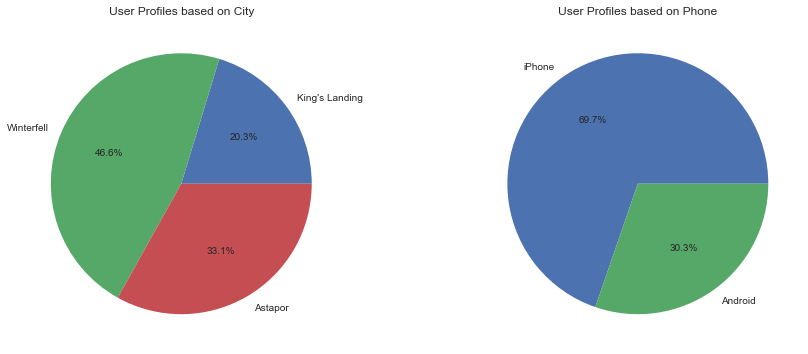

In [27]:
#user profiles based on city and phone
c_sizes = [one_hot_df['King\'s Landing'].sum(), one_hot_df['Winterfell'].sum(), (ultimate_df.city == 'Astapor').sum()]
c_labels = ['King\'s Landing', 'Winterfell','Astapor']
p_sizes = [one_hot_df['iPhone'].sum(), (ultimate_df.phone == 'Android').sum()]
p_labels = ['iPhone','Android']

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.pie(c_sizes, labels=c_labels, autopct='%1.1f%%')
plt.title('User Profiles based on City')

plt.subplot(122)
plt.pie(p_sizes, labels=p_labels, autopct='%1.1f%%')
plt.title('User Profiles based on Phone')

Text(0.5, 1.0, 'Total number of users based on month of last trip')

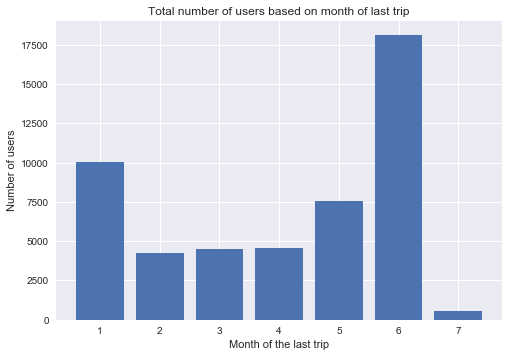

In [28]:
#user profiles based on last_trip_date's month
lt_months = []
for lt_date in ultimate_df.last_trip_date:
    lt_months.append(lt_date.month)
    
one_hot_df['last_trip_months'] = lt_months

months = [1,2,3,4,5,6,7]
plt.bar(months, one_hot_df.groupby('last_trip_months')['avg_dist'].count())
plt.xlabel('Month of the last trip')
plt.ylabel('Number of users')
plt.title('Total number of users based on month of last trip')

As stated earlier, about 36.65% of the total users are retained and have used the services in the last month. 

Text(0.5, 1.0, 'Total number of users based on day of the month of last trip')

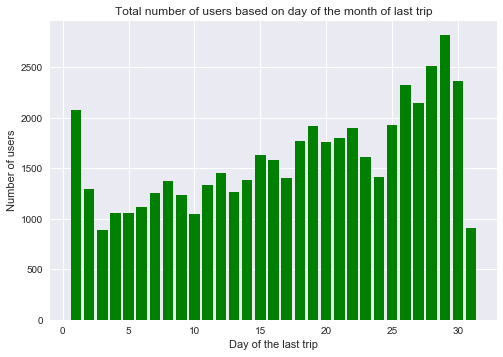

In [29]:
#user profiles based on last_trip_date's day
lt_days = []
for lt_date in ultimate_df.last_trip_date:
    lt_days.append(lt_date.day)
    
one_hot_df['last_trip_day'] = lt_days

days = [d for d in range(1,32)]
plt.bar(days, one_hot_df.groupby('last_trip_day')['avg_dist'].count(), color='g')
plt.xlabel('Day of the last trip')
plt.ylabel('Number of users')
plt.title('Total number of users based on day of the month of last trip')

Users generally tend to increase their usage of the Ultimate service as the month end nears. 

### Multicollinearity Analysis

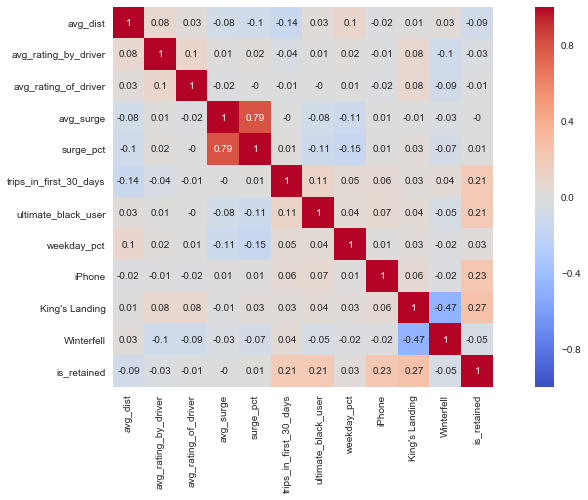

In [30]:
# Running a correlation matrix
import seaborn as sns
plt.figure(figsize=(15,7))
sns.heatmap(ultimate_df.corr().round(2),square=True,annot=True,cmap='coolwarm',vmin=-1, vmax=1)

As can be seen, avg_surge and surge_pct have a large correlation. Let's drop one of these values along with our dummy variables. But before that, for feature selection and checks for multicollinearity, a variance inflation factor analysis should be implemented. 

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

non_categ_ultimate_df = ultimate_df.drop(['iPhone','King\'s Landing','Winterfell','city','phone','last_trip_date','signup_date'], axis=1)

#Multicollinearity analysis
#Get features
feature_x = non_categ_ultimate_df.drop(['is_retained'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
1,66.816097,avg_rating_by_driver
2,52.064869,avg_rating_of_driver
3,48.786436,avg_surge
7,3.796125,weekday_pct
4,2.819295,surge_pct


With such high VIF values for the first two variables, a high multicollinearity exists. We can try to remove the avg_rating_by_driver, and running the VIF analysis again. 

In [32]:
non_categ_ultimate_df = non_categ_ultimate_df.drop('avg_rating_by_driver', axis=1)

In [33]:
#Get features
feature_x = non_categ_ultimate_df.drop(['is_retained'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
2,36.385978,avg_surge
1,31.137657,avg_rating_of_driver
6,3.761050,weekday_pct
3,2.527055,surge_pct
0,2.117866,avg_dist


Dropping the avg_surge, we can further reduce multicollinearity.

In [34]:
non_categ_ultimate_df = non_categ_ultimate_df.drop('avg_surge', axis=1)
feature_x = non_categ_ultimate_df.drop(['is_retained'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
1,5.575587,avg_rating_of_driver
5,3.701069,weekday_pct
0,2.110036,avg_dist
4,1.630342,ultimate_black_user
3,1.404056,trips_in_first_30_days


This is looking much better!

In [35]:
one_hot_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,iPhone,King's Landing,Winterfell,is_retained,last_trip_months,last_trip_day
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,1,1,0,True,6,17
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,0,0,0,False,5,5
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,1,0,0,False,1,7
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,1,1,0,True,6,29
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,1,False,3,15


In [36]:
#Therefore the final dataframe needed for robust analysis would be as follows:
X = one_hot_df.drop(['avg_rating_by_driver', 'avg_surge','last_trip_date','signup_date','is_retained'], axis=1) 

#converting the categories as category types
X[['iPhone','King\'s Landing','Winterfell','last_trip_months','last_trip_day','ultimate_black_user']] = X[['iPhone','King\'s Landing','Winterfell','last_trip_months','last_trip_day','ultimate_black_user']].astype('category') 

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 11 columns):
avg_dist                  49604 non-null float64
avg_rating_of_driver      49604 non-null float64
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null category
weekday_pct               49604 non-null float64
iPhone                    49604 non-null category
King's Landing            49604 non-null category
Winterfell                49604 non-null category
last_trip_months          49604 non-null category
last_trip_day             49604 non-null category
dtypes: category(6), float64(4), int64(1)
memory usage: 3.8 MB


### MinMax Scaling

Right before analysis, we would opt for  a scaling procedure built into the pipeline, to increase the accuracy. 

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#Scaling the variables
scaled_X = scaler.fit_transform(X[['avg_dist','avg_rating_of_driver','surge_pct',
                                   'trips_in_first_30_days','weekday_pct']])

#Converting the transformed array into a dataframe
scaled_df = pd.DataFrame(scaled_X, columns=['avg_dist','avg_rating_of_driver','surge_pct',
                                   'trips_in_first_30_days','weekday_pct'])

C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [39]:
#Dropping the older unscaled columns
drop_unscaled_X = X.drop(['avg_dist','avg_rating_of_driver','surge_pct',
                                   'trips_in_first_30_days','weekday_pct'], axis=1).reset_index()

#Joining the two dataframes together
scaled_df_complete = scaled_df.join(drop_unscaled_X)
scaled_df_complete.head()

,avg_dist,avg_rating_of_driver,surge_pct,trips_in_first_30_days,weekday_pct,index,ultimate_black_user,iPhone,King's Landing,Winterfell,last_trip_months,last_trip_day
0,0.022801,0.925,0.154,0.032,0.462,0,True,1,1,0,6,17
1,0.051317,1.000,0.000,0.000,0.500,1,False,0,0,0,5,5
2,0.004784,0.825,0.000,0.024,1.000,2,False,1,0,0,1,7
3,0.014662,0.900,0.200,0.072,0.800,3,True,1,1,0,6,29
4,0.019446,0.850,0.118,0.112,0.824,4,False,0,0,1,3,15


2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

Since this is a classification task, to determine whether a user would be active in the 6th month on the system, we will go with ROC curves, confusion matrix, and classification reports. 

In [40]:
#Importing the Machine Learning Modules and Metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, accuracy_score

In [41]:
#Splitting the data into train and test sets
y = one_hot_df.is_retained

X_train, X_test, y_train, y_test = train_test_split(scaled_df_complete, y, test_size=0.2, random_state=38)

### Logistic Regression

In [42]:
#Establishing a baseline for classification results using simple logistic regression. 
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='liblinear',max_iter = 500, random_state=36)

#cross-validate on training set
cv_log_reg = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')

#fitting the model
log_reg.fit(X_train,y_train)

#predicting the model values
y_predict = log_reg.predict(X_test)

In [43]:
#printing out the results of the model
print('Train accuracy: {}'.format(cv_log_reg.mean()))
print('Test accuracy: {}'.format(accuracy_score(y_test, y_predict)))
conf_mat_log_reg = pd.DataFrame(confusion_matrix(y_test, y_predict), columns=['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])
print('Confusion matrix: ')
print(conf_mat_log_reg)
print('Classification report: ')
print(classification_report(y_test, y_predict))

Train accuracy: 0.8791145430654126
Test accuracy: 0.8443705271646004
Confusion matrix: 
          Predicted 0  Predicted 1
Actual 0         5104         1189
Actual 1          355         3273
Classification report: 
              precision    recall  f1-score   support

       False       0.93      0.81      0.87      6293
        True       0.73      0.90      0.81      3628

   micro avg       0.84      0.84      0.84      9921
   macro avg       0.83      0.86      0.84      9921
weighted avg       0.86      0.84      0.85      9921



These values are quite good for a classification model, and I would start to optimize my hyperparameters based on these results. But let us also try with a linear support vector machine model and check its values.

### Linear Support Vector Machines

A support vector machine creates a boundary between the two classes, and is used for classification of less than 100000 samples. A linear SVM is the simplest of these SVMs creating a hyperplane, and can result in really good accuracy in results. 

In [44]:
from sklearn.svm import LinearSVC
#from sklearn.calibration import CalibratedClassifierCV

svc_lin = LinearSVC(C=0.1, max_iter=500, random_state=36)
#calibrated_svc = CalibratedClassifierCV(svc_lin, method='sigmoid', cv=3)

#cross-validate on training set
cv_svc_lin = cross_val_score(svc_lin, X_train, y_train, cv=5, scoring='accuracy')

#fitting the model
svc_lin.fit(X_train,y_train)

#predicting the model values
y_predict_svc = svc_lin.predict(X_test)

C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

In [45]:
#printing out the results of the model
print('Train accuracy: {}'.format(cv_svc_lin.mean()))
print('Test accuracy: {}'.format(accuracy_score(y_test, y_predict_svc)))
conf_mat_svc_lin = pd.DataFrame(confusion_matrix(y_test, y_predict_svc), columns=['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])
print('Confusion matrix: ')
print(conf_mat_svc_lin)
print('Classification report: ')
print(classification_report(y_test, y_predict_svc))

Train accuracy: 0.8582513635642686
Test accuracy: 0.9099889124080234
Confusion matrix: 
          Predicted 0  Predicted 1
Actual 0         5839          454
Actual 1          439         3189
Classification report: 
              precision    recall  f1-score   support

       False       0.93      0.93      0.93      6293
        True       0.88      0.88      0.88      3628

   micro avg       0.91      0.91      0.91      9921
   macro avg       0.90      0.90      0.90      9921
weighted avg       0.91      0.91      0.91      9921



It is evident that the linear SVM performs quite nicely with the data, and gives us high accuracy, precision and recall scores. Let us optimize this model!

In [46]:
#creating a parameter grid for optimizing the C parameter
param_grid = {'C':[1e-3, 1e-2, 1e-1, 1]}   #gamma parameter will be set to default, as this is a linear kernel

#initializing the gridsearch estimator
svc_gs = GridSearchCV(svc_lin, param_grid=param_grid, cv=5)

#fitting the train data to this new GridSearch
svc_gs.fit(X_train, y_train)

C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=500,
     multi_class='ovr', penalty='l2', random_state=36, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

Now that the grid search parameter has been trained, (C=0.1 seems to be the best parameter), we will look at the classification report again. 

In [47]:
#printing out the results of the optimized Linear SVC model
print('Train accuracy: {}'.format(svc_gs.score(X_train, y_train)))
print('Test accuracy: {}'.format(accuracy_score(y_test, svc_gs.predict(X_test))))
conf_mat_svc_gs = pd.DataFrame(confusion_matrix(y_test, svc_gs.predict(X_test)), columns=['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])
print('Confusion matrix: ')
print(conf_mat_svc_gs)
print('Classification report: ')
print(classification_report(y_test,svc_gs.predict(X_test)))

Train accuracy: 0.9077942695864728
Test accuracy: 0.9099889124080234
Confusion matrix: 
          Predicted 0  Predicted 1
Actual 0         5839          454
Actual 1          439         3189
Classification report: 
              precision    recall  f1-score   support

       False       0.93      0.93      0.93      6293
        True       0.88      0.88      0.88      3628

   micro avg       0.91      0.91      0.91      9921
   macro avg       0.90      0.90      0.90      9921
weighted avg       0.91      0.91      0.91      9921



The area under the curve is 0.9677542433087918


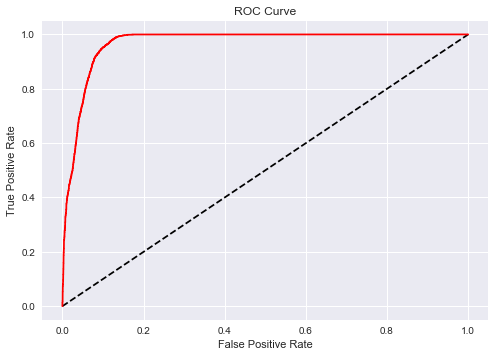

In [48]:
#visualizing the ROC curve
#importing necessary modules
#we need to 
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = svc_gs.decision_function(X_test)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
print('The area under the curve is {}'.format(roc_auc_score(y_test, y_pred_prob)))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


Thus, the SVM model seems to really find a great fit for the data, and can be leveraged to determine whether a user would be retained in the 6th month, up to 90.1% test accuracy.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

Let's examine a feature importance graph to gain insights on the most important features. 

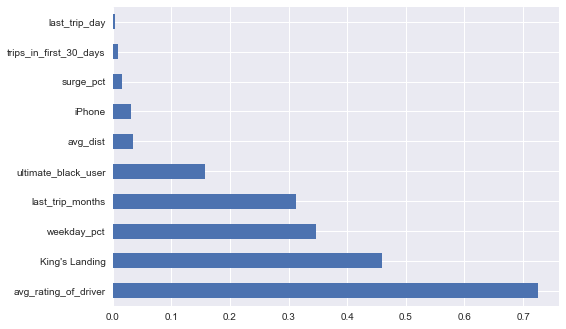

In [49]:
pd.Series(abs(svc_lin.coef_[0]), index=X_train.columns).nlargest(10).plot(kind='barh')

Ultimate can definitely pay close attention to the average rating of driver, whether the user signed up from King's Landing and if they have a high precentage of rides occurring during a weekday. These factors determine the retention level of a user 6 months down the line.